In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure,exposure, color
from skimage import segmentation as skseg
from skimage.util import img_as_float
from skimage.future import graph
import cv2 as cv


from insitro_data.utils import db_utils
from ml_projects.posh.utils import data, fluorescence,microscope
from ml_projects.microscopy_common.utils import plate
from ml_projects.posh.utils import image as image_utils



In [54]:
def normalize(raw_image:np.ndarray):
    '''
    Function that normalises the image
    input : single channe 2D image
    '''
    image = cv.normalize(
        raw_image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F
    )
    return image

def open_as_composite_image(image_path):
    '''
    Function that opens the image in the given file path, normalises across the brainbow flurophores and creates a composite RGB image
    
    input: path to image
    '''
    
    # read in the image
    random_image = data.read_numpy_image(image_path,image_storage_format = "CHW")
    random_image.shape

    #create composite image
#     comp = np.stack([normalize(random_image[channel_map['mKate2']]).astype('uint8'),
#                      normalize(random_image[channel_map['mOrange']]).astype('uint8'),
#                      normalize(random_image[channel_map['eGFP']]).astype('uint8')],
#                         axis =2)
    comp = np.stack([(random_image[channel_map['mKate2']]).astype('uint8'),
                     (random_image[channel_map['mOrange']]).astype('uint8'),
                     (random_image[channel_map['eGFP']]).astype('uint8')],
                        axis =2)

#     
    return comp

def plot_channelwise(image):
    '''
    Plot the composite and individual channels of a given composite image
    '''

    fig = plt.figure(figsize=(8, 2),dpi=300)
    fig.subplots_adjust(hspace = 0, wspace= 0)
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.imshow(exposure.adjust_gamma(image, gamma =1, gain = 2),alpha=0.9)
    ax1.axis('off')
    ax1.set_title('Composite')

    ax2.imshow(exposure.adjust_gamma(image[:,:,2], gamma =1, gain = 2),cmap='Blues_r')
    ax2.axis('off')
    ax2.set_title('eGFP')

    ax3.imshow(exposure.adjust_gamma(image[:,:,1], gamma =1, gain = 2),cmap='Greens_r')
    ax3.axis('off')
    ax3.set_title('mOrange')

    ax4.imshow(exposure.adjust_gamma(image[:,:,0], gamma =1, gain = 2),cmap='Reds_r')
    ax4.axis('off')
    ax4.set_title('mKate2')

    fig.show()


def image_colorfulness(image):
    # split the image into its respective RGB components
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    
    # compute rg = R - G
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    
    # derive the "colorfulness" metric and return it
    colorfulness = stdRoot + (0.3 * meanRoot)
    
    return colorfulness



def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

In [68]:
plate_id = 'PC2089' #plate id
microscope_id = 6 # techdev scope or nikon 4
#Fluroscent map
channel_map ={
    'DAPI':1,
    'eGFP':2,
    'mOrange':0,
    'mKate2':3,
    'DPC_top':4,
    'DPC_bottom':5,
    'DPC_left':6,
    'DPC_right':7
}
#sql query : note that is is based on the plate map
query = (
    f"select * from canonical_image where plate_barcode = 'PC2089' AND microscope_id = 6 AND measurement_id != 'b9aeb061-1d0f-4186-8b39-80e7251c9b60'")


In [69]:
#connect to the sql database and extract the experiment info
engine = db_utils.get_readonly_research_db_engine()
con = engine.connect()
experiment = pd.read_sql(query, con)


In [70]:
control_paths = experiment[experiment.well_column == 1].file_path
ca137_0 = experiment[(experiment.well_column == 2) & (experiment.well_row == 1)].file_path
ca137_250 = experiment[(experiment.well_column == 2) & (experiment.well_row == 2)].file_path
ca137_500 = experiment[(experiment.well_column == 2) & (experiment.well_row == 3)].file_path
ca137_1000 = experiment[(experiment.well_column == 2) & (experiment.well_row == 4)].file_path


cm137_0 = experiment[(experiment.well_column == 3) & (experiment.well_row == 1)].file_path
cm137_250 = experiment[(experiment.well_column == 3) & (experiment.well_row == 2)].file_path
cm137_500 = experiment[(experiment.well_column == 3) & (experiment.well_row == 3)].file_path
cm137_1000 = experiment[(experiment.well_column == 3) & (experiment.well_row == 4)].file_path

cd118_0 = experiment[(experiment.well_column == 4) & (experiment.well_row == 1)].file_path
cd118_250 = experiment[(experiment.well_column == 4) & (experiment.well_row == 2)].file_path
cd118_500 = experiment[(experiment.well_column == 4) & (experiment.well_row == 3)].file_path
cd118_1000 = experiment[(experiment.well_column == 4) & (experiment.well_row == 4)].file_path


cm130_0 = experiment[(experiment.well_column == 5) & (experiment.well_row == 1)].file_path
cm130_250 = experiment[(experiment.well_column == 5) & (experiment.well_row == 2)].file_path
cm130_500 = experiment[(experiment.well_column == 5) & (experiment.well_row == 3)].file_path
cm130_1000 = experiment[(experiment.well_column == 5) & (experiment.well_row == 4)].file_path


In [35]:
image_path = np.random.choice(experiment.file_path)


## inspect samples

### Control

In [71]:
image_path = np.random.choice(ca137_500)
#randomly select a image from the control sample, open, normalise across channels and create a composite image
image_path = np.random.choice(control_paths)
image = open_as_composite_image(image_path)

142.0749766494052

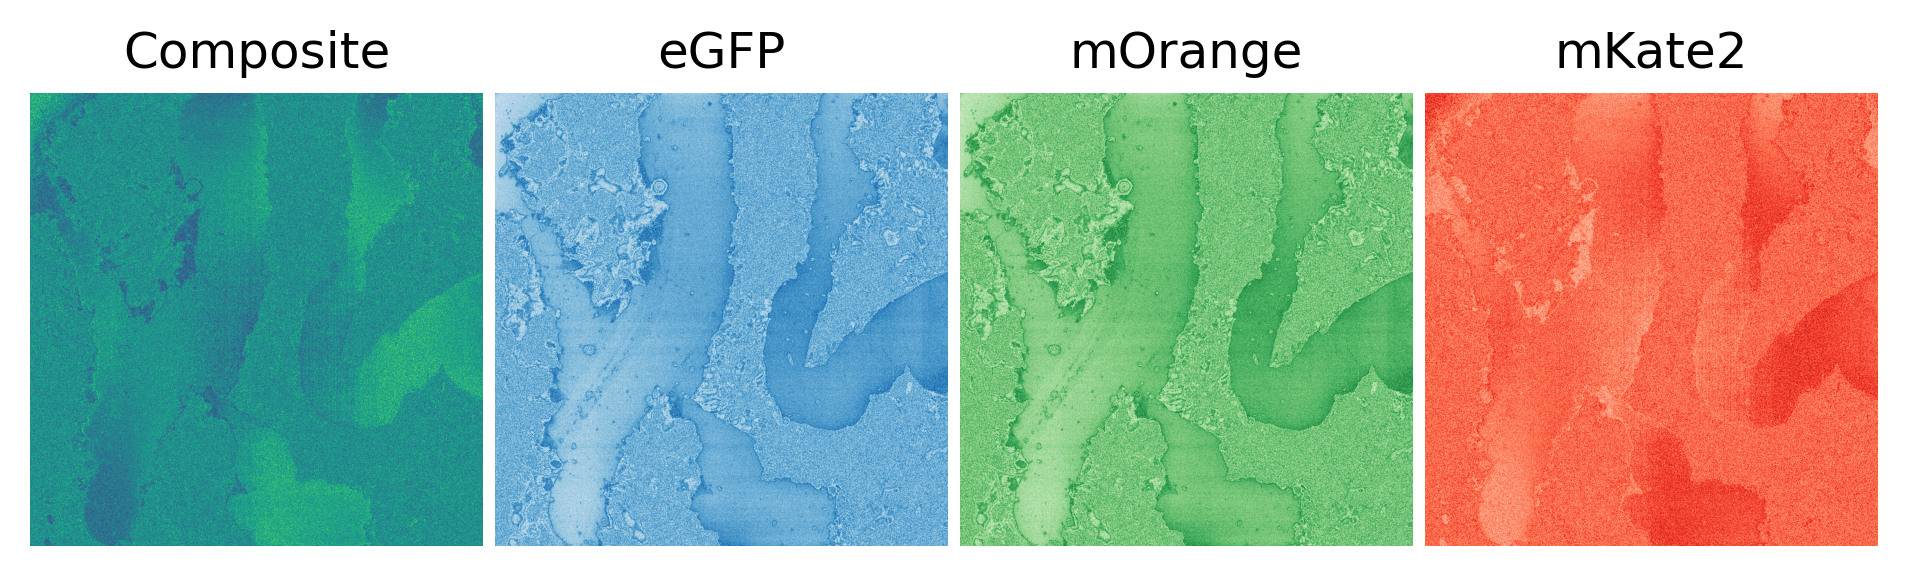

In [72]:

#Visualise each flurophore

fig = plt.figure(figsize=(8, 2),dpi=300)
fig.subplots_adjust(hspace = 0, wspace= 0)
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Composite')

ax2.imshow(exposure.adjust_gamma(image[:,:,1], gamma =1, gain = 1),cmap='Blues')
ax2.axis('off')
ax2.set_title('eGFP')

ax3.imshow(exposure.adjust_gamma(image[:,:,1], gamma =1, gain = 1),cmap='Greens')
ax3.axis('off')
ax3.set_title('mOrange')

ax4.imshow(exposure.adjust_gamma(image[:,:,0], gamma =1, gain = 1),cmap='Reds')
ax4.axis('off')
ax4.set_title('mKate2')

fig.show()
image_colorfulness(image)    